In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astropy.io import fits
import os
from astropy.wcs import WCS
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm
import numpy as np
from reproject import reproject_interp
from regions import Regions
from matplotlib.colors import LinearSegmentedColormap, Normalize

import sys
sys.path.append('/home/t.yoo/Paths')
import Paths.Paths as paths

Path = paths.filepaths()

class PiecewiseNormalize(Normalize):
    def __init__(self, vmin1, vmax1, vmin2, vmax2, turn_value):
        super().__init__(vmin=vmin1, vmax=vmax2)
        self.vmin1 = vmin1
        self.vmax1 = vmax1
        self.vmin2 = vmin2
        self.vmax2 = vmax2
        self.turn_value = turn_value
        self.norm_low = simple_norm([vmin1, vmax1], stretch='log', min_cut=vmin1, max_cut=vmax1)
        self.norm_high = simple_norm([vmin2, vmax2], stretch='log', min_cut=vmin2, max_cut=vmax2)

    def __call__(self, value, clip=None):
        value = np.ma.array(value)
        # Map low values to [0, 0.5]
        low_mask = value <= self.turn_value
        high_mask = ~low_mask

        result = np.ma.empty(value.shape)
        result[low_mask] = 0.5 * self.norm_low(value[low_mask])
        result[high_mask] = 0.5 + 0.5 * self.norm_high(value[high_mask])
        return result



def make_rgb_image(repr480_image_filenames, filt1, filt2, filt3, cutout_region=None,
    alpha_red=0.7, alpha_green=0.78, alpha_blue=0.74, 
    figsize=(48,20),
    vmin_img1=-2.12, vmax_img1=3987, vmin_img2=-2.12, vmax_img2=2409, vmin_img3=-2.12, vmax_img3=798, 
    color_scheme='rgb', stretch='log', ax=None, swap_width_height=False):
    """
    Create an RGB image from three filters.
    """
    img1 = fits.getdata(repr480_image_filenames[filt1])
    img2 = fits.getdata(repr480_image_filenames[filt2])
    img3 = fits.getdata(repr480_image_filenames[filt3])

    ref_fits = fits.open(repr480_image_filenames['f480m'])
    tgt_header = fits.getheader(repr480_image_filenames['f480m'])

    wcs_header = WCS(tgt_header)
    if color_scheme == 'rgb':
        cmap1 = LinearSegmentedColormap.from_list('red', [(0, 0, 0), (1, 0, 0)])
        cmap2 = LinearSegmentedColormap.from_list('green', [(0, 0, 0), (0, 1, 0)])
        cmap3 = LinearSegmentedColormap.from_list('blue', [(0, 0, 0), (0, 0, 1)])
    elif color_scheme == 'cmyk':
        cmap1 = LinearSegmentedColormap.from_list('magenta', [(0, 0, 0), (1, 0, 1)])
        cmap2 = LinearSegmentedColormap.from_list('yellow', [(0, 0, 0), (1, 1, 0)])
        cmap3 = LinearSegmentedColormap.from_list('cyan', [(0, 0, 0), (0, 1, 1)])

    if cutout_region is not None:
        from regions import Regions
        from astropy.nddata import Cutout2D
        if not swap_width_height:
            cutout1 = Cutout2D(img1, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
            cutout2 = Cutout2D(img2, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
            cutout3 = Cutout2D(img3, cutout_region.center, (cutout_region.width, cutout_region.height), wcs=wcs_header)
        else:
            cutout1 = Cutout2D(img1, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
            cutout2 = Cutout2D(img2, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
            cutout3 = Cutout2D(img3, cutout_region.center, (cutout_region.height, cutout_region.width), wcs=wcs_header)
        img1 = cutout1.data
        img2 = cutout2.data
        img3 = cutout3.data

    if stretch == 'log':
        norm1 = simple_norm(img1, stretch='log', vmin=vmin_img1, vmax=vmax_img1)
        norm2 = simple_norm(img2, stretch='log', vmin=vmin_img2, vmax=vmax_img2)
        norm3 = simple_norm(img3, stretch='log', vmin=vmin_img3, vmax=vmax_img3)
    elif stretch == 'linear':
        norm1 = simple_norm(img1, stretch='linear', vmin=vmin_img1, vmax=vmax_img1)
        norm2 = simple_norm(img2, stretch='linear', vmin=vmin_img2, vmax=vmax_img2)
        norm3 = simple_norm(img3, stretch='linear', vmin=vmin_img3, vmax=vmax_img3)

    color1_rgb = cmap1(norm1(img1))[...,:3] * alpha_red
    color2_rgb  = cmap2(norm2(img2))[...,:3]  * alpha_green
    color3_rgb    = cmap3(norm3(img3))[...,:3]    * alpha_blue

    composite = color1_rgb + color2_rgb + color3_rgb
    composite = np.clip(composite, 0, 1)

    if ax is not None:

        #fig = plt.figure(figsize=figsize )
        #ax = fig.add_subplot(111, projection=wcs_header)

        ax.imshow(composite, origin='lower', )
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')


        ra = lon = ax.coords['ra']
        dec = lat = ax.coords['dec']
        ra.set_major_formatter('hh:mm:ss.ss')
        dec.set_major_formatter('dd:mm:ss.ss')
        ra.set_axislabel('Right Ascension')
        ra.set_ticklabel(rotation=25, pad=30)
        dec.set_axislabel('Declination')
        
        ra.set_ticks_position('l')
        ra.set_ticklabel_position('l')
        ra.set_axislabel_position('l')
        dec.set_ticks_position('b')
        dec.set_ticklabel_position('b')
        dec.set_axislabel_position('b')
    if cutout_region is not None:
        return composite, cutout1.wcs
    else:
        return composite


image_filenames ={
    "f140m": "/orange/adamginsburg/jwst/w51/F140M/pipeline/jw06151-o001_t001_nircam_clear-f140m-merged_i2d.fits",
    "f150w": "/orange/adamginsburg/jwst/w51/F150W/pipeline/jw06151-o001_t001_nircam_clear-f150w-merged_i2d.fits",
    "f162m": "/orange/adamginsburg/jwst/w51/F162M/pipeline/jw06151-o001_t001_nircam_clear-f162m-merged_i2d.fits",
    "f182m": "/orange/adamginsburg/jwst/w51/F182M/pipeline/jw06151-o001_t001_nircam_clear-f182m-merged_i2d.fits",
    "f187n": "/orange/adamginsburg/jwst/w51/F187N/pipeline/jw06151-o001_t001_nircam_clear-f187n-merged_i2d.fits",
    "f210m": "/orange/adamginsburg/jwst/w51/F210M/pipeline/jw06151-o001_t001_nircam_clear-f210m-merged_i2d.fits",
    "f335m": "/orange/adamginsburg/jwst/w51/F335M/pipeline/jw06151-o001_t001_nircam_clear-f335m-merged_i2d.fits",
    "f360m": "/orange/adamginsburg/jwst/w51/F360M/pipeline/jw06151-o001_t001_nircam_clear-f360m-merged_i2d.fits",
    "f405n": "/orange/adamginsburg/jwst/w51/F405N/pipeline/jw06151-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": "/orange/adamginsburg/jwst/w51/F410M/pipeline/jw06151-o001_t001_nircam_clear-f410m-merged_i2d.fits", # weird, the filename is different from what is downloaded with the STScI pipeline...
    "f480m": "/orange/adamginsburg/jwst/w51/F480M/pipeline/jw06151-o001_t001_nircam_clear-f480m-merged_i2d.fits",
    "f560w": "/orange/adamginsburg/jwst/w51/F560W/pipeline/jw06151-o002_t001_miri_f560w_i2d.fits",
    "f770w": "/orange/adamginsburg/jwst/w51/F770W/pipeline/jw06151-o002_t001_miri_f770w_i2d.fits",
    "f1000w": "/orange/adamginsburg/jwst/w51/F1000W/pipeline/jw06151-o002_t001_miri_f1000w_i2d.fits",
    "f1280w": "/orange/adamginsburg/jwst/w51/F1280W/pipeline/jw06151-o002_t001_miri_f1280w_i2d.fits",
    "f1500w": "/orange/adamginsburg/jwst/w51/F1500W/pipeline/jw06151-o002_t001_miri_f1500w_i2d.fits",
    "f2100w": "/orange/adamginsburg/jwst/w51/F2100W/pipeline/jw06151-o002_t001_miri_f2100w_i2d.fits",
    "f405n-f410m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits",
    "f187n-f182m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f187n_minus_f182m.fits",


}

ref_fits = fits.open(image_filenames['f140m'])

tgt_header = fits.getheader(image_filenames['f140m'], ext=('SCI', 1))
wcs_header = WCS(tgt_header, naxis=2)

reg_h2k = Regions.read('/orange/adamginsburg/w51/TaehwaYoo/region_jwst_highlights/h2k_highlights.reg')



reproj_dir = '/orange/adamginsburg/jwst/w51/data_reprojected_140_expanded/'
repr140_image_filenames = {x: y.replace("i2d", "i2d_reprj_f140") for x,y in image_filenames.items()}
repr140_image_filenames = {x: (reproj_dir+os.path.basename(y)) for x,y in repr140_image_filenames.items()}


#h2k_gtc_image = fits.getdata('/orange/adamginsburg/w51/TaehwaYoo/gtc/adendawson/real_reduction/reduced_images/H2_minus_K.fits')
#h2k_gtc_wcs = WCS(fits.getheader('/orange/adamginsburg/w51/TaehwaYoo/gtc/adendawson/real_reduction/reduced_images/H2_minus_K.fits'))
#h2k_gtc_reproj_image, _ = reproject_interp((h2k_gtc_image, h2k_gtc_wcs), wcs_header, )
h2k_gtc_reproj_image = fits.getdata(reproj_dir+'H2_minus_K_reprj_f140.fits')
h2k_gtc_reproj_wcs = WCS(fits.getheader(reproj_dir+'H2_minus_K_reprj_f140.fits'),naxis=2)


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


15
ind 0
[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 1


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 2


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 3


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 4


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 5


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 6


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 7


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 8


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 9


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 10


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 11


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 12


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056
ind 13


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056


Set OBSGEO-B to   -25.271881 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441536.798 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[8.67472981e-06 8.67472981e-06]
32.02149045023056


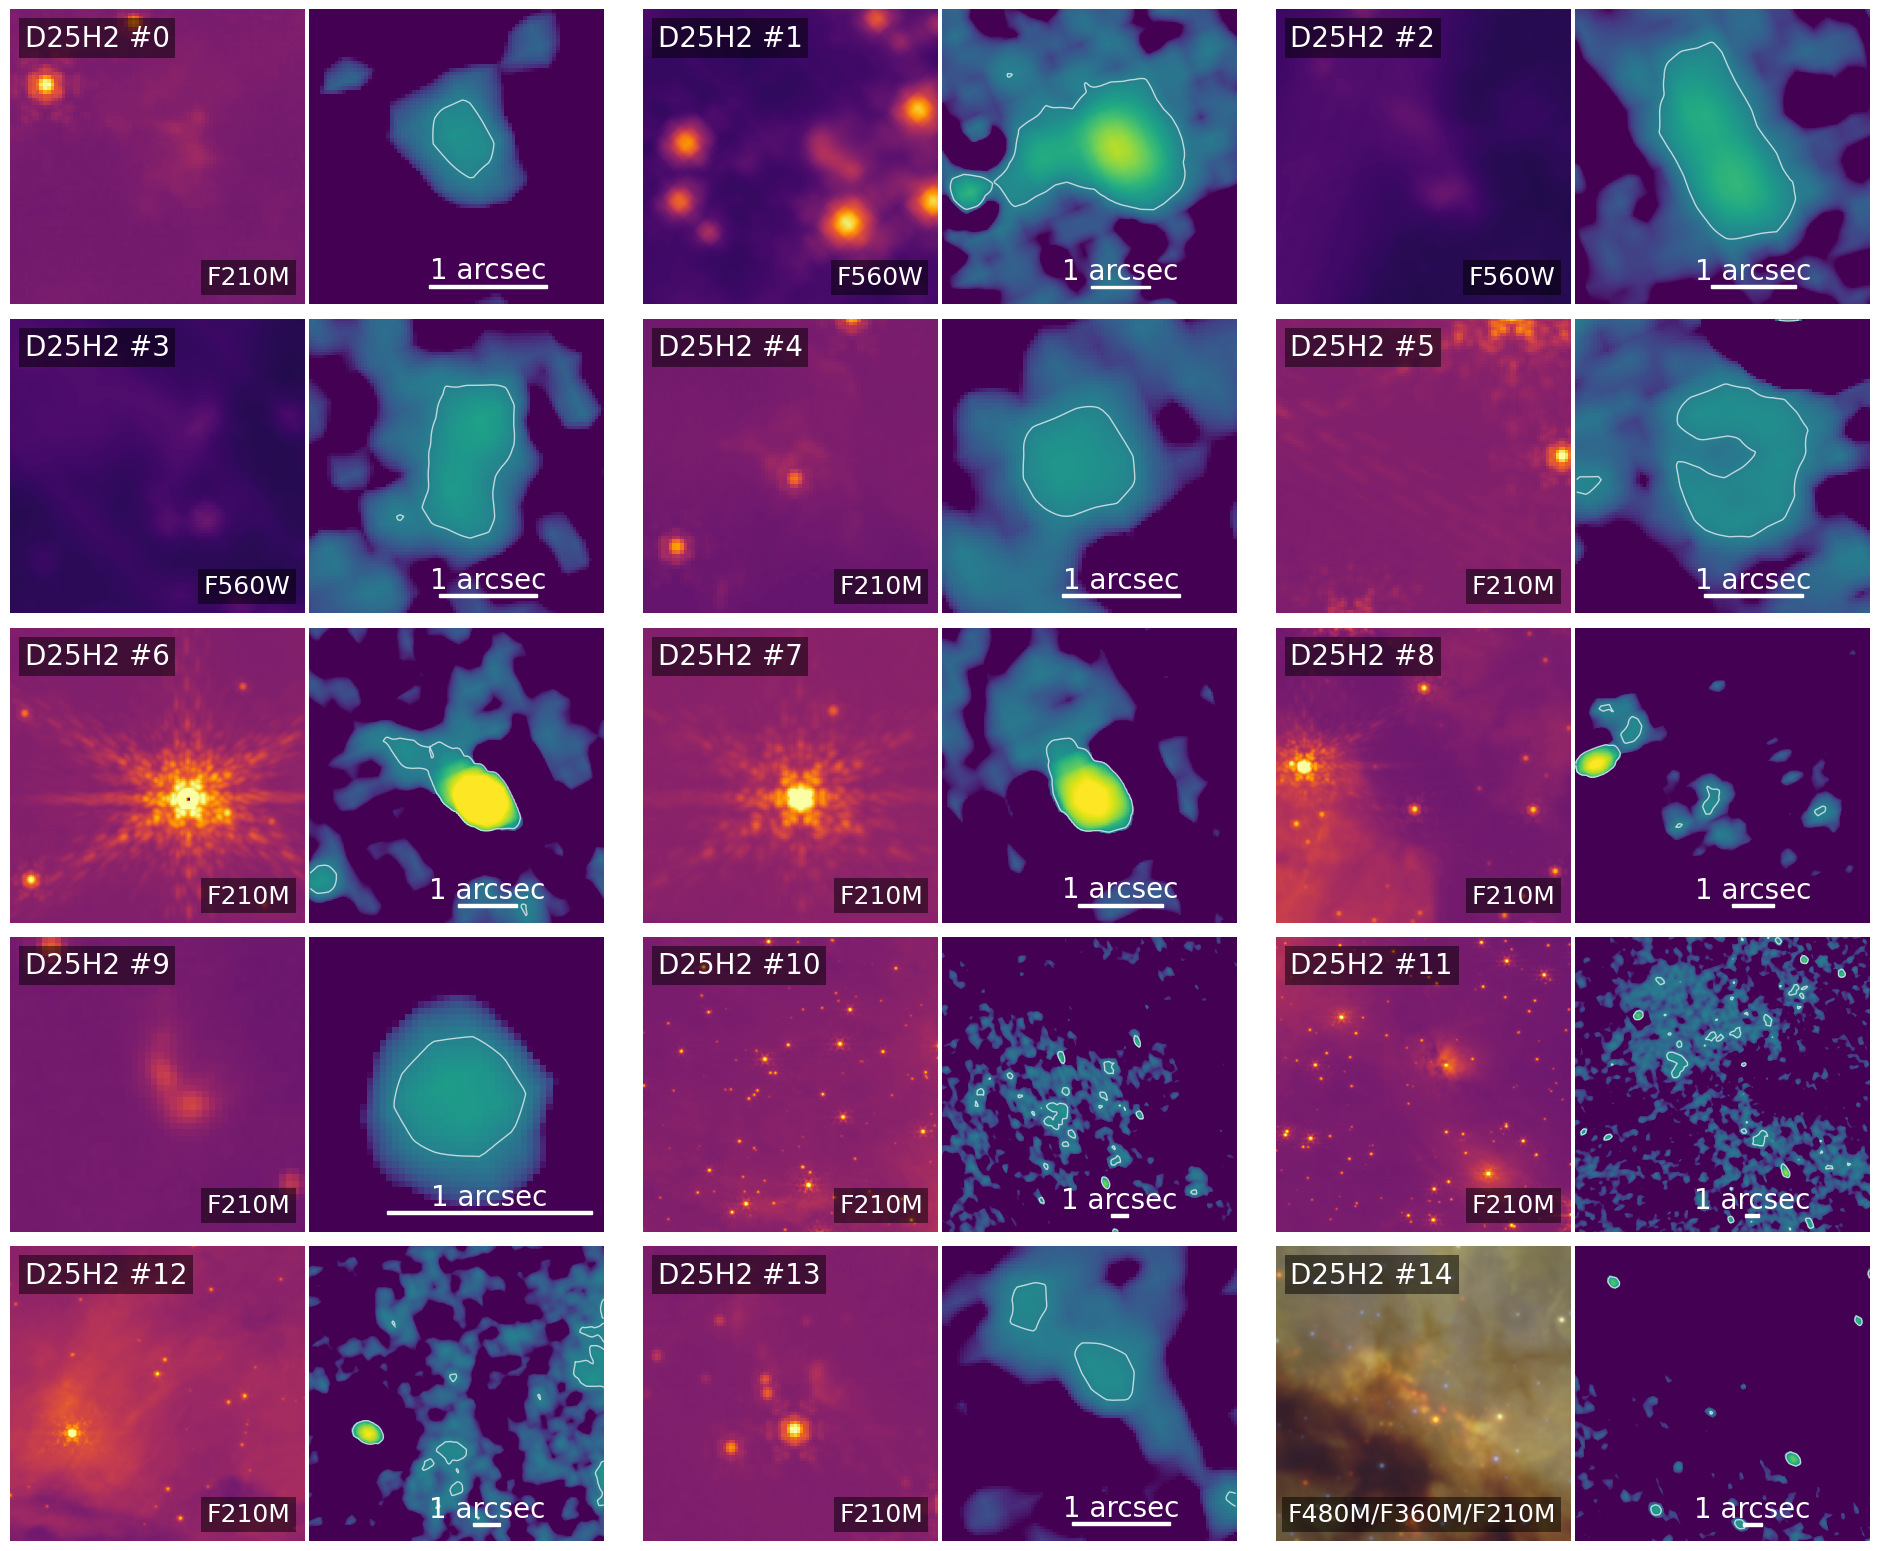

In [4]:
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib.patches import Rectangle

def add_scalebar(ax, xpos, ypos, length, pixel_scale, label=None, color='white', fontsize=20, bbox=False, pad=0.05, thickness=5):

    scaled_length = (length / pixel_scale).to(u.deg/u.deg)
    print(scaled_length)
    ax.add_patch(Rectangle((xpos-scaled_length.value/2, ypos), scaled_length.value, thickness, color=color))
    if label:
        if bbox:
            ax.text(xpos, ypos + pad, label, color=color, fontsize=fontsize, ha='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        else:
            ax.text(xpos, ypos + pad, label, color=color, fontsize=fontsize, ha='center')
    
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15


plot_params= {14:
    {'filt1': 'f480m', 'filt2': 'f360m', 'filt3': 'f210m',
     'alpha_red': 1, 'alpha_green': 1, 'alpha_blue': 1,
     'vmin_img1': 0.09660550444184562, 'vmax_img1': 1750.5999232117263,
     'vmin_img2':0.004751104975596244, 'vmax_img2': 1526.653229560062,
     'vmin_img3': -1.221155232132053, 'vmax_img3': 940.7141462681723,
     'color_scheme': 'rgb', 'stretch': 'log',
      'swap_width_height': False,
      'xtext':'left', 'ytext':'bottom'}}


ind=0
cmap_low = plt.get_cmap('gray')
cmap_high = plt.get_cmap('afmhot')
vmin1 = -10
vmin2 = 0
vmax1 = 15
vmax2 = 5000
fig = plt.figure(figsize=(24, 20))
gs = gridspec.GridSpec(5, 8, figure=fig, hspace=0.02, wspace=0.02, width_ratios=[1,1,0.1,1,1,0.1,1,1])
print(len(reg_h2k))
for i in range(5):
    for j in range(3):
        if ind<14:
            if ind == 1 or ind==2 or ind==3:
                filt = 'f560w'
                vmin = -8.238391068626964
                vmax = 3588.159084883629
            else:
                filt = 'f210m'
                vmin = -1.221155232132053
                vmax = 301.7755108099539
            print('ind', ind)
            img1 = fits.getdata(repr140_image_filenames[filt])
            wcs_img1 = WCS(fits.getheader(repr140_image_filenames[filt]))
            ax1 = fig.add_subplot(gs[i,j*3], projection= wcs_img1)

            cutout1 = Cutout2D(img1, reg_h2k[ind].center, (reg_h2k[ind].width, reg_h2k[ind].height), wcs= wcs_img1)
            norm1 = simple_norm(img1, stretch='log', vmin=vmin, vmax=vmax)
            ax1.imshow(cutout1.data, origin='lower', norm=norm1, cmap='inferno')
            ax1.text(0.05, 0.95, f'D25H2 #{ind}', transform=ax1.transAxes, fontsize=20, color='white', ha='left', va='top', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            ax1.text(0.95, 0.05, f'{filt.upper()}', transform=ax1.transAxes, fontsize=18, color='white', ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

        elif ind == 14:
            cutout1, cutout_wcs = make_rgb_image(repr140_image_filenames,
                                plot_params[ind]['filt1'], plot_params[ind]['filt2'], plot_params[ind]['filt3'],
                                alpha_red=plot_params[ind]['alpha_red'], alpha_green=plot_params[ind]['alpha_green'], 
                                alpha_blue=plot_params[ind]['alpha_blue'],
                                vmin_img1=plot_params[ind]['vmin_img1'], vmax_img1=plot_params[ind]['vmax_img1'],
                                vmin_img2=plot_params[ind]['vmin_img2'], vmax_img2=plot_params[ind]['vmax_img2'],
                                vmin_img3=plot_params[ind]['vmin_img3'], vmax_img3=plot_params[ind]['vmax_img3'],
                                color_scheme=plot_params[ind]['color_scheme'], stretch=plot_params[ind]['stretch'],
                                swap_width_height=plot_params[ind]['swap_width_height'], cutout_region=reg_h2k[ind],)
            ax1 = fig.add_subplot(gs[i,j*3], projection= cutout_wcs)
            norm1 = simple_norm(img1, stretch='log', vmin=vmin, vmax=vmax)
            ax1.imshow(cutout1.data, origin='lower', norm=norm1, cmap='inferno')
            ax1.text(0.05, 0.95, f'D25H2 #{ind}', transform=ax1.transAxes, fontsize=20, color='white', ha='left', va='top', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            filt1_str = plot_params[ind]['filt1'].upper()
            filt2_str = plot_params[ind]['filt2'].upper()
            filt3_str = plot_params[ind]['filt3'].upper()
            ax1.text(0.95, 0.05, f'{filt1_str}/{filt2_str}/{filt3_str}', transform=ax1.transAxes, fontsize=18, color='white', ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax2 = fig.add_subplot(gs[i,j*3+1], projection=wcs_header)

        cutout2 = Cutout2D(h2k_gtc_reproj_image, reg_h2k[ind].center, (reg_h2k[ind].width, reg_h2k[ind].height), wcs=h2k_gtc_reproj_wcs)
        """
        norm_low = simple_norm(cutout2.data, stretch='log', min_cut=vmin1, max_cut=vmax1)
        norm_high = simple_norm(cutout2.data, stretch='log', min_cut=vmin2, max_cut=vmax2)
        n_low = 128
        n_high = 128
        colors_low = cmap_low(np.linspace(0, 1, n_low))
        colors_high = cmap_high(np.linspace(0, 1, n_high))
        combined_colors = np.vstack((colors_low, colors_high))
        combined_cmap = LinearSegmentedColormap.from_list('CombinedLogCmap', combined_colors)
        norm_combined = PiecewiseNormalize(vmin1, vmax1, vmin2, vmax2, 10)
        """
        norm = simple_norm(cutout2.data, stretch='log', vmin=0.5, vmax=500)
        ax2.imshow(cutout2.data, origin='lower', norm=norm, cmap=plt.get_cmap('viridis'))
        levels=[10]
        ax2.contour(cutout2.data, levels=levels, colors='w', linewidths=1, alpha=0.7)

        ax1.xaxis.label.set_visible(False)
        ax1.yaxis.label.set_visible(False)
        ax1.set_axis_off()
        ax2.xaxis.label.set_visible(False)
        ax2.yaxis.label.set_visible(False)
        ax2.set_axis_off()
        print(proj_plane_pixel_scales(h2k_gtc_reproj_wcs))
        add_scalebar(ax2, 0.6* cutout2.data.shape[1], 0.05*cutout2.data.shape[0], 1*u.arcsec, proj_plane_pixel_scales(h2k_gtc_reproj_wcs)[0]*u.deg, label='1 arcsec', color='white', fontsize=20, pad=0.03*cutout2.data.shape[0], thickness=0.01*cutout2.data.shape[0])
        #ax2.set_xlim(0, cutout2.data.shape[1])
        #ax2.set_ylim(0, cutout2.data.shape[0])

        
        ind = ind+1
plt.savefig('plots/h2k_cutouts.png', bbox_inches='tight', dpi=300)